In [1]:
import re
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

!pip install category_encoders
import category_encoders as ce


In [206]:
# Importation du fichier de scraping
df = pd.read_csv(r'C:\Users\Qw\Desktop\projet_gaming\vgsales_Zak.csv')

# Recherche des données manquantes
df.isnull().sum()

#encoding la colonne Publisher ==> OrdinalEncoder ()
ord_enc = ce.OrdinalEncoder()
df[["Genre","Publisher", "Platform","developper"]] = ord_enc.fit_transform(df[["Genre","Publisher","Platform","developper"]])

# supprimer les colonnes inutiles
df = df.drop(['Rank','Name','gamename','samename','Global_Sales'], axis=1)

df.head()

,developper,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,metaNote,metaNbVote,userNote,userNbVote,Like_Percent,metaNoteQ,serieB
0,1,1,2006,1,1,41.49,29.02,3.77,8.46,76,51,8.1,453,0.96,4,1
1,1,2,1985,2,1,29.08,3.58,6.81,0.77,84,14,8.5,98,0.92,4,1
2,1,1,2008,3,1,15.85,12.88,3.79,3.31,82,73,8.4,1047,0.96,4,0
3,1,1,2009,1,1,15.75,11.01,3.28,2.96,80,73,8.2,293,0.97,4,1
4,1,3,1989,4,1,23.20,2.26,4.22,0.58,83,27,8.2,258,0.00,4,0


<AxesSubplot:>

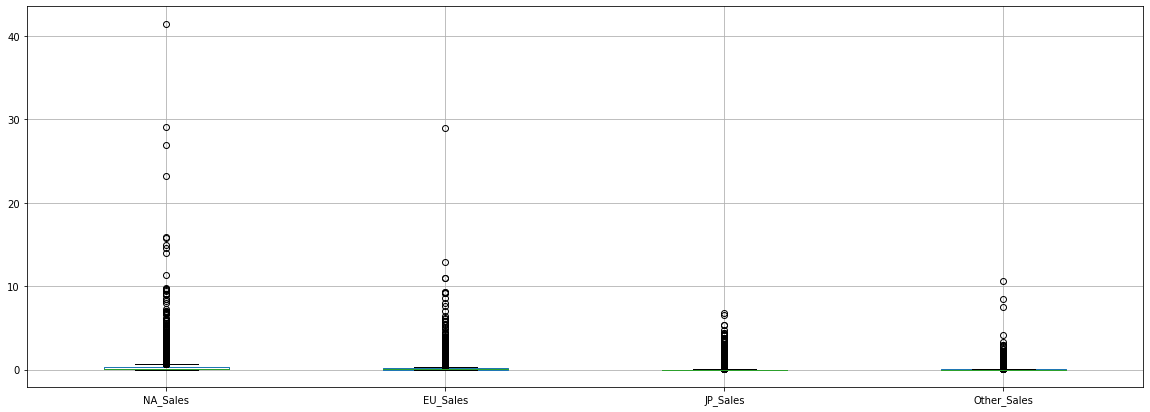

In [207]:
# les valeurs aberrantes df
df.boxplot(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'], figsize=(20,7))

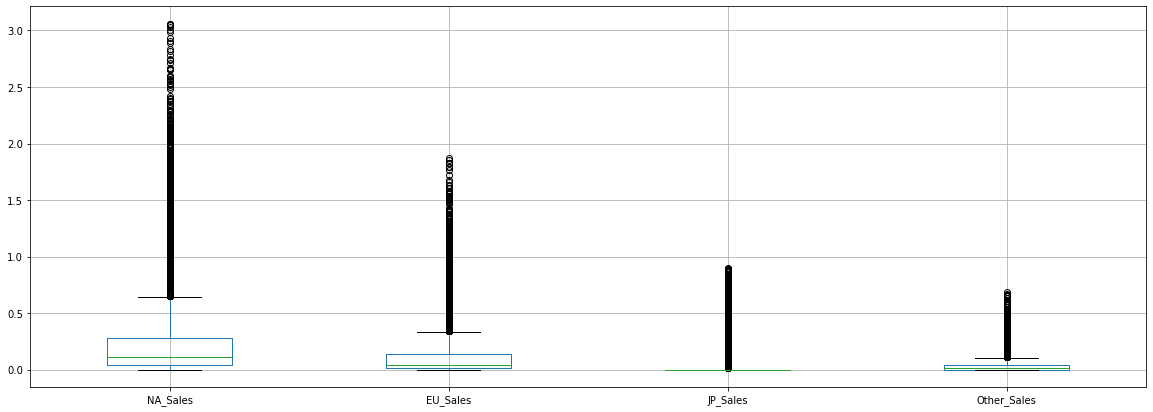

In [208]:
# supprimer les valeurs aberrantes en utilisant zscore:
    # définition zscore:
        # formule (x - la moyenne)/ecart-type de chaque colonne
    # l'objectif :
        # est de standardiser le df afin de transformer les valeurs en une seule unité de mesure
        # et ensuite supprimer les valeurs aberrantes qui sont supérieur à 2 (<3)
        # car le zscore se situe entre -3 et 3.
from scipy import stats
new_df2=df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
new_df2
# verification des valeures aberrantes new_df2
new_df2.boxplot(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'], figsize=(20,7));

### 1- Modèle linear Regression (sans outliers)

              valeur_estimee
intercept           2.552547
developper         -0.000015
Platform            0.000677
Year               -0.001268
Genre               0.000184
Publisher          -0.000007
NA_Sales            0.117764
JP_Sales            0.071504
Other_Sales         2.004806
metaNote            0.000052
metaNbVote         -0.000133
userNote           -0.000204
userNbVote          0.000041
Like_Percent       -0.003358
metaNoteQ           0.000431
serieB             -0.002604 

le coeficient de determination sur train (R²) 0.6742779466940583
le coeficient de determination sur train (CV) 0.6731212890102143


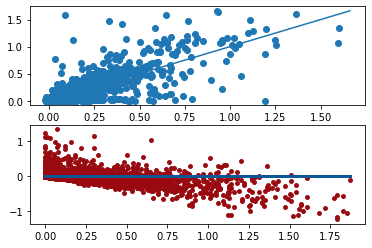

In [209]:
df2 = new_df2

"""# 1-preprocessing
sc = StandardScaler().fit(df2)
df2[df2.columns]=pd.DataFrame(sc.transform(df2), index=df2.index)
df2"""

# 2 - définir data et target
data=df2.drop('EU_Sales', axis=1)
target=df2['EU_Sales']

# 3- train + test
X_train,X_test, y_train, y_test= train_test_split(data, target,test_size=0.2)

# 4-modèle et paramètre
lr=LinearRegression()
lr.fit(X_train, y_train)

# 5- ntercept_ et coef_ (ax+b)
coef=list(lr.coef_)
coef.insert(0,lr.intercept_)
feat=list(data.columns)
feat.insert(0,'intercept')
print(pd.DataFrame({'valeur_estimee':coef}, index=feat),'\n')

# 6- performance train
print('le coeficient de determination sur train (R²)', lr.score(X_train,y_train))
print('le coeficient de determination sur train (CV)', cross_val_score(lr,X_train,y_train).mean())

# 7- prediction
y_pred= lr.predict(X_test)
plt.subplot(2,1,1)
plt.scatter(y_pred,y_test)
plt.plot((y_test.min(),y_test.max()),(y_test.min(),y_test.max()));

# 8-fonction coût (erreur)
pred_train = lr.predict(X_train)
residus = pred_train - y_train
plt.subplot(2,1,2)
plt.scatter(y_train, residus, color='#980a10', s=15)
plt.plot((y_train.min(), y_train.max()), (0, 0), lw=3, color='#0a5798')

# 9-améliorer le modèle




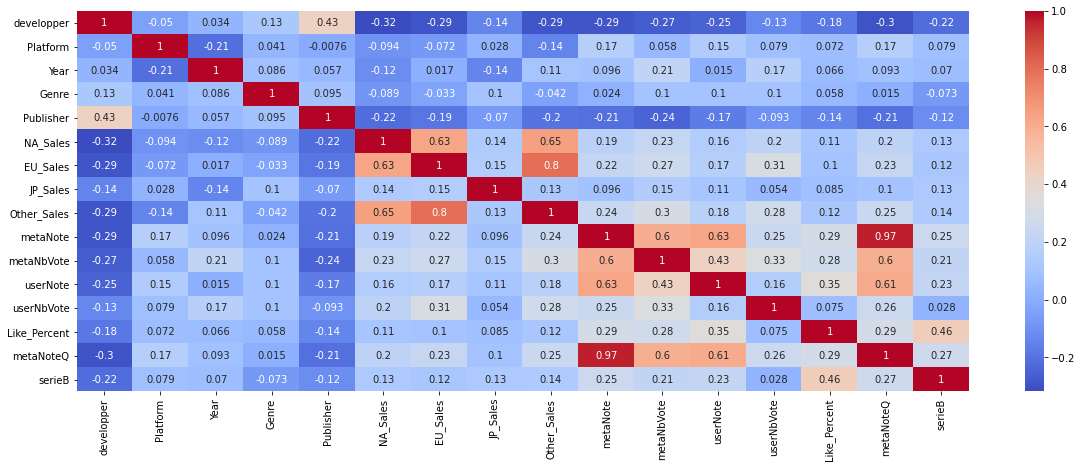

In [193]:
plt.figure(figsize=(20,7))
sns.heatmap(df2.corr(),annot=True,cmap='coolwarm');

### 2- Modèle Ridge 

In [210]:
df2 = new_df2

# 1-preprocessing
sc = StandardScaler().fit(df2)
df2[df2.columns]=pd.DataFrame(sc.transform(df2), index=df2.index)
df2

# 2- data + target
data=df2.drop('NA_Sales', axis=1)
target=df2['NA_Sales']

# 3- train + test
X_train,X_test, y_train, y_test= train_test_split(data, target,test_size=0.2)

# 4- le modèle Ridge
from sklearn.linear_model import RidgeCV
ridge_reg=RidgeCV(alphas=(0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))
ridge_reg.fit(X_train, y_train)

# 5- alphas retenu
print('alphas retenu par le modèle: ', ridge_reg.alpha_)

# 6- performance
print("le score R² sur l'ensemble de train",ridge_reg.score(X_train, y_train))
print("le score R² sur l'ensemble de test",ridge_reg.score(X_test, y_test) )

# 7- predict
ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

# 8- fonction cout (erreur)
from sklearn.metrics import mean_squared_error
print('mse train:', mean_squared_error(ridge_pred_train, y_train))
print('mse test:', mean_squared_error(ridge_pred_test, y_test))


C:\Users\Qw\anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


alphas retenu par le modèle:  100.0
le score R² sur l'ensemble de train 0.4992806051665696
le score R² sur l'ensemble de test 0.5170933224559445
mse train: 0.5085613147101924
mse test: 0.4525529416525103


### 3- Modèle Lasso 

les coef sont nuls donc il faut modifier l'alpha 
 [-0. -0. -0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.] 

[-0.04288743 -0.         -0.04878844 -0.         -0.          0.22813678
  0.          0.3726708   0.          0.          0.          0.
  0.          0.          0.        ] 

score R² sur l'ensemeble de train 0.47209638536231424
score R² sur l'ensemeble de test 0.447864859430509


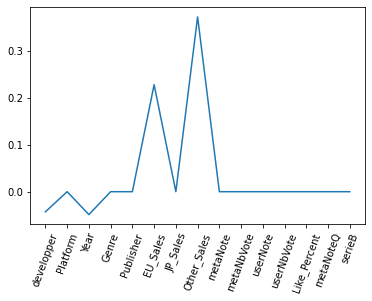

In [211]:
# 1- preprocessing df2 :  déjà normalisé

# 2- data + target
data=df2.drop('NA_Sales', axis=1)
target=df2['NA_Sales']

# 3- train + test
X_train,X_test, y_train, y_test= train_test_split(data, target,test_size=0.2)

# 4- le modèle Ridge
from sklearn.linear_model import Lasso
lasso_r1 = Lasso(alpha=1)
lasso_r1.fit(X_train, y_train)
    # ==> 5- coef estimé par le modèle
print("les coef sont nuls donc il faut modifier l'alpha",'\n',lasso_r1.coef_,'\n') # 

# 6- changer l'alpha par 0.1
lasso_r2 = Lasso(alpha=0.1)
lasso_r2.fit(X_train, y_train)
    # ==> 7- coef estimé par le modèle
print(lasso_r2.coef_,'\n')

# 8- les variables choisi par le modèle
coef_estime = lasso_r2.coef_
plt.plot(range(len(data.columns)),coef_estime)
plt.xticks(range(len(data.columns)), data.columns.values, rotation=70);

# 9- Performance
print("score R² sur l'ensemeble de train", lasso_r2.score(X_train,y_train))
print("score R² sur l'ensemeble de test", lasso_r2.score(X_test,y_test))

### 4- Modèle Elastic Net

les coefficients et l'intercept 
               valeurs estimée
intercept            0.001928
developper          -0.090314
Platform            -0.063417
Year                -0.178293
Genre               -0.031153
Publisher           -0.017241
EU_Sales             0.296193
JP_Sales             0.004892
Other_Sales          0.367665
metaNote            -0.008909
metaNbVote           0.042650
userNote             0.004067
userNbVote           0.012833
Like_Percent         0.012027
metaNoteQ            0.000000
serieB               0.023062 

RMSE train : 0.7048829752391185
RMSE train : 0.7074421867849198 

score R² train =  0.5112911057414964
score R² test =  0.4636717478893523 

moyenne : 0.43878822739909884
ecart-type : 0.49623897357528823 



,données_obsérvés,données_predits
5296,0.418589,0.0
668,2.472878,1.0
6661,0.271854,0.0
722,1.725864,1.0
818,1.779222,1.0
1315,0.952171,1.0
781,1.605808,1.0


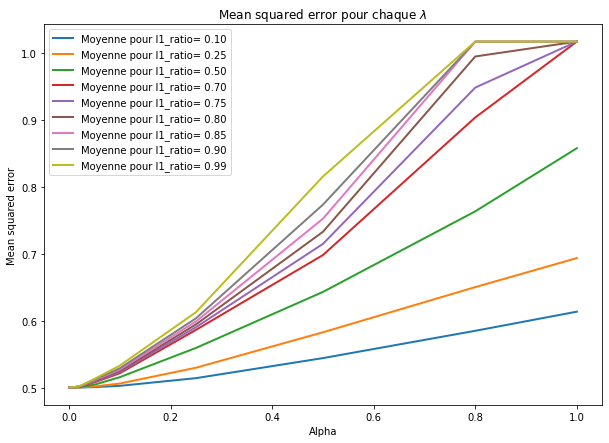

In [212]:
# 1- preprocessing df2 :  déjà normalisé

# 2- data + target
data=df2.drop('NA_Sales', axis=1)
target=df2['NA_Sales']

# 3- train + test
X_train,X_test, y_train, y_test= train_test_split(data, target,test_size=0.2)

# 4- modèle Elastic net (permet une combinaison entre Ridge et Lasso )
from sklearn.linear_model import ElasticNetCV
encv = ElasticNetCV(cv=8,l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99) ,
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0))
encv.fit(X_train, y_train)

# 5- afficher les coefficients et l'intercept
coeffs = list(encv.coef_)
coeffs.insert(0, encv.intercept_)
feats = list(data.columns)
feats.insert(0, 'intercept')
print("les coefficients et l'intercept",'\n',pd.DataFrame({'valeurs estimée':coeffs}, index=feats),'\n')

# 6- la fonction cout (erreur) pour chaque l1_ratio
alphas = encv.alphas_
plt.figure(figsize=(10, 7))

for i in range(encv.mse_path_.shape[0]) :
    plt.plot(alphas, encv.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %encv.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();

# 7- predict
pred_train = encv.predict(X_train) 
pred_test = encv.predict(X_test)
    # 8- la fonction cout (erreur)
print('RMSE train :', np.sqrt(mean_squared_error(y_train, pred_train)))
print('RMSE train :', np.sqrt(mean_squared_error(y_test, pred_test)),'\n')

# 9- la performance
print('score R² train = ',encv.score(X_train, y_train) )
print('score R² test = ',encv.score(X_test, y_test), '\n')

# 10-  Afficher les données véritablement observés pour chaque jeu,
        #et les données prédits par le modèle Elastic Net
moy = sc.mean_[-1]
ec = sc.scale_[-1]
print('moyenne :', moy)
print('ecart-type :', ec, '\n')

pd.DataFrame({'données_obsérvés': (y_test*ec)+moy, 'données_predits' : np.round((pred_test*ec)+moy)}, 
             index=X_test.index).head(7)

### 5- Regression logistique


### 6- arbre de décision
